In [20]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import shapiro, skew
from scipy.cluster.hierarchy import dendrogram, linkage
from joblib import Memory
from textwrap import fill


In [2]:
DEFAULT_CRS = "EPSG:4326"
RANDOM_STATE = 42

In [5]:
dados = gpd.read_file('data/WGS84_hex_agg.gpkg')

In [12]:
col_dic = { 
    "qnt_unidades_sum": "Soma quantidade de Unidades IPTU",
    "qnt_unidades_mean": "Média quantidade de Unidades IPTU",
    "qnt_unidades_median": "Mediana quantidade de Unidades IPTU",
    "qnt_unidades_std": "Desvio Padrão quantidade de Unidades IPTU",
    "qnt_unidades_var": "Variância quantidade de Unidades IPTU",
    "area_sum": "Soma da área de construção Open Buildings",
    "area_mean": "Média da área de construção Open Buildings",
    "area_median": "Mediana da área de construção Open Buildings",
    "area_var": "Variância Soma da área de construção Open Buildings",
    "area_std": "Desvio Padrão Soma da área de construção Open Buildings",
    "area_count": "Quantidade de construção Open Buildings",
    "D1_012_d_sum": "Quantidade de domicílios com acesso à rede de água da rede geral CENSO 2010",
    "D1_017_d_sum": "Quantidade de domicílios com acesso à rede de esgoto geral CENSO 2010",
    "D1_035_d_sum": "Quantidade de domicílios com lixo coletado CENSO 2010",
    "D1_044_d_sum": "Quantidade de domicílios com energia elétrica de companhia distribuidora CENSO 2010",
}


In [13]:
df = dados[col_dic.keys()]

In [14]:
print(list(df.columns))

['qnt_unidades_sum', 'qnt_unidades_mean', 'qnt_unidades_median', 'qnt_unidades_std', 'qnt_unidades_var', 'area_sum', 'area_mean', 'area_median', 'area_var', 'area_count', 'D1_012_d_sum', 'D1_017_d_sum', 'D1_035_d_sum', 'D1_044_d_sum']


## Olhar as distribuições das variaiveis

In [21]:
# Função para plotar o gridplot de histogramas e testar a normalidade e skewness
def plot_distributions_and_tests(df):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()  # Selecionar apenas colunas numéricas
    n_cols = 3  # Definir o número de colunas no grid
    n_rows = int(np.ceil(len(num_cols) / n_cols))  # Definir o número de linhas com base no número de colunas
    
    # Criar o gridplot
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten()  # Flatten a matriz de eixos para acessar individualmente
    
    for i, col in enumerate(num_cols):
        sns.histplot(df[col], bins=30, kde=True, ax=axes[i])  # Gerar histograma com KDE (Kernel Density Estimate)
        title = fill(f'Histograma de {col_dic[col]}', width=40)
        axes[i].set_title(title)
        
        # Teste de normalidade Shapiro-Wilk
        stat, p_value = shapiro(df[col].dropna())  # Descartar valores nulos
        normality = "Normal" if p_value > 0.05 else "Não Normal"
        
        # Cálculo de skewness
        skewness_val = skew(df[col].dropna())
        skewness_type = "Positiva" if skewness_val > 0 else "Negativa"
        
        # Mostrar resultados no título do plot
        axes[i].set_xlabel(f'Skewness: {skewness_val:.2f} ({skewness_type})\nTeste Shapiro: p={p_value:.3f} ({normality})')

    # Remover gráficos em branco, se houver
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j])

    # Ajustar layout
    plt.tight_layout()
    plt.show()

# Exemplo de uso
# Supondo que você tenha um DataFrame 'df'
# plot_distributions_and_tests(df)

/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 105505.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 105505.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 105505.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 105505.
  res = hypotest_fun_out(*samples, 

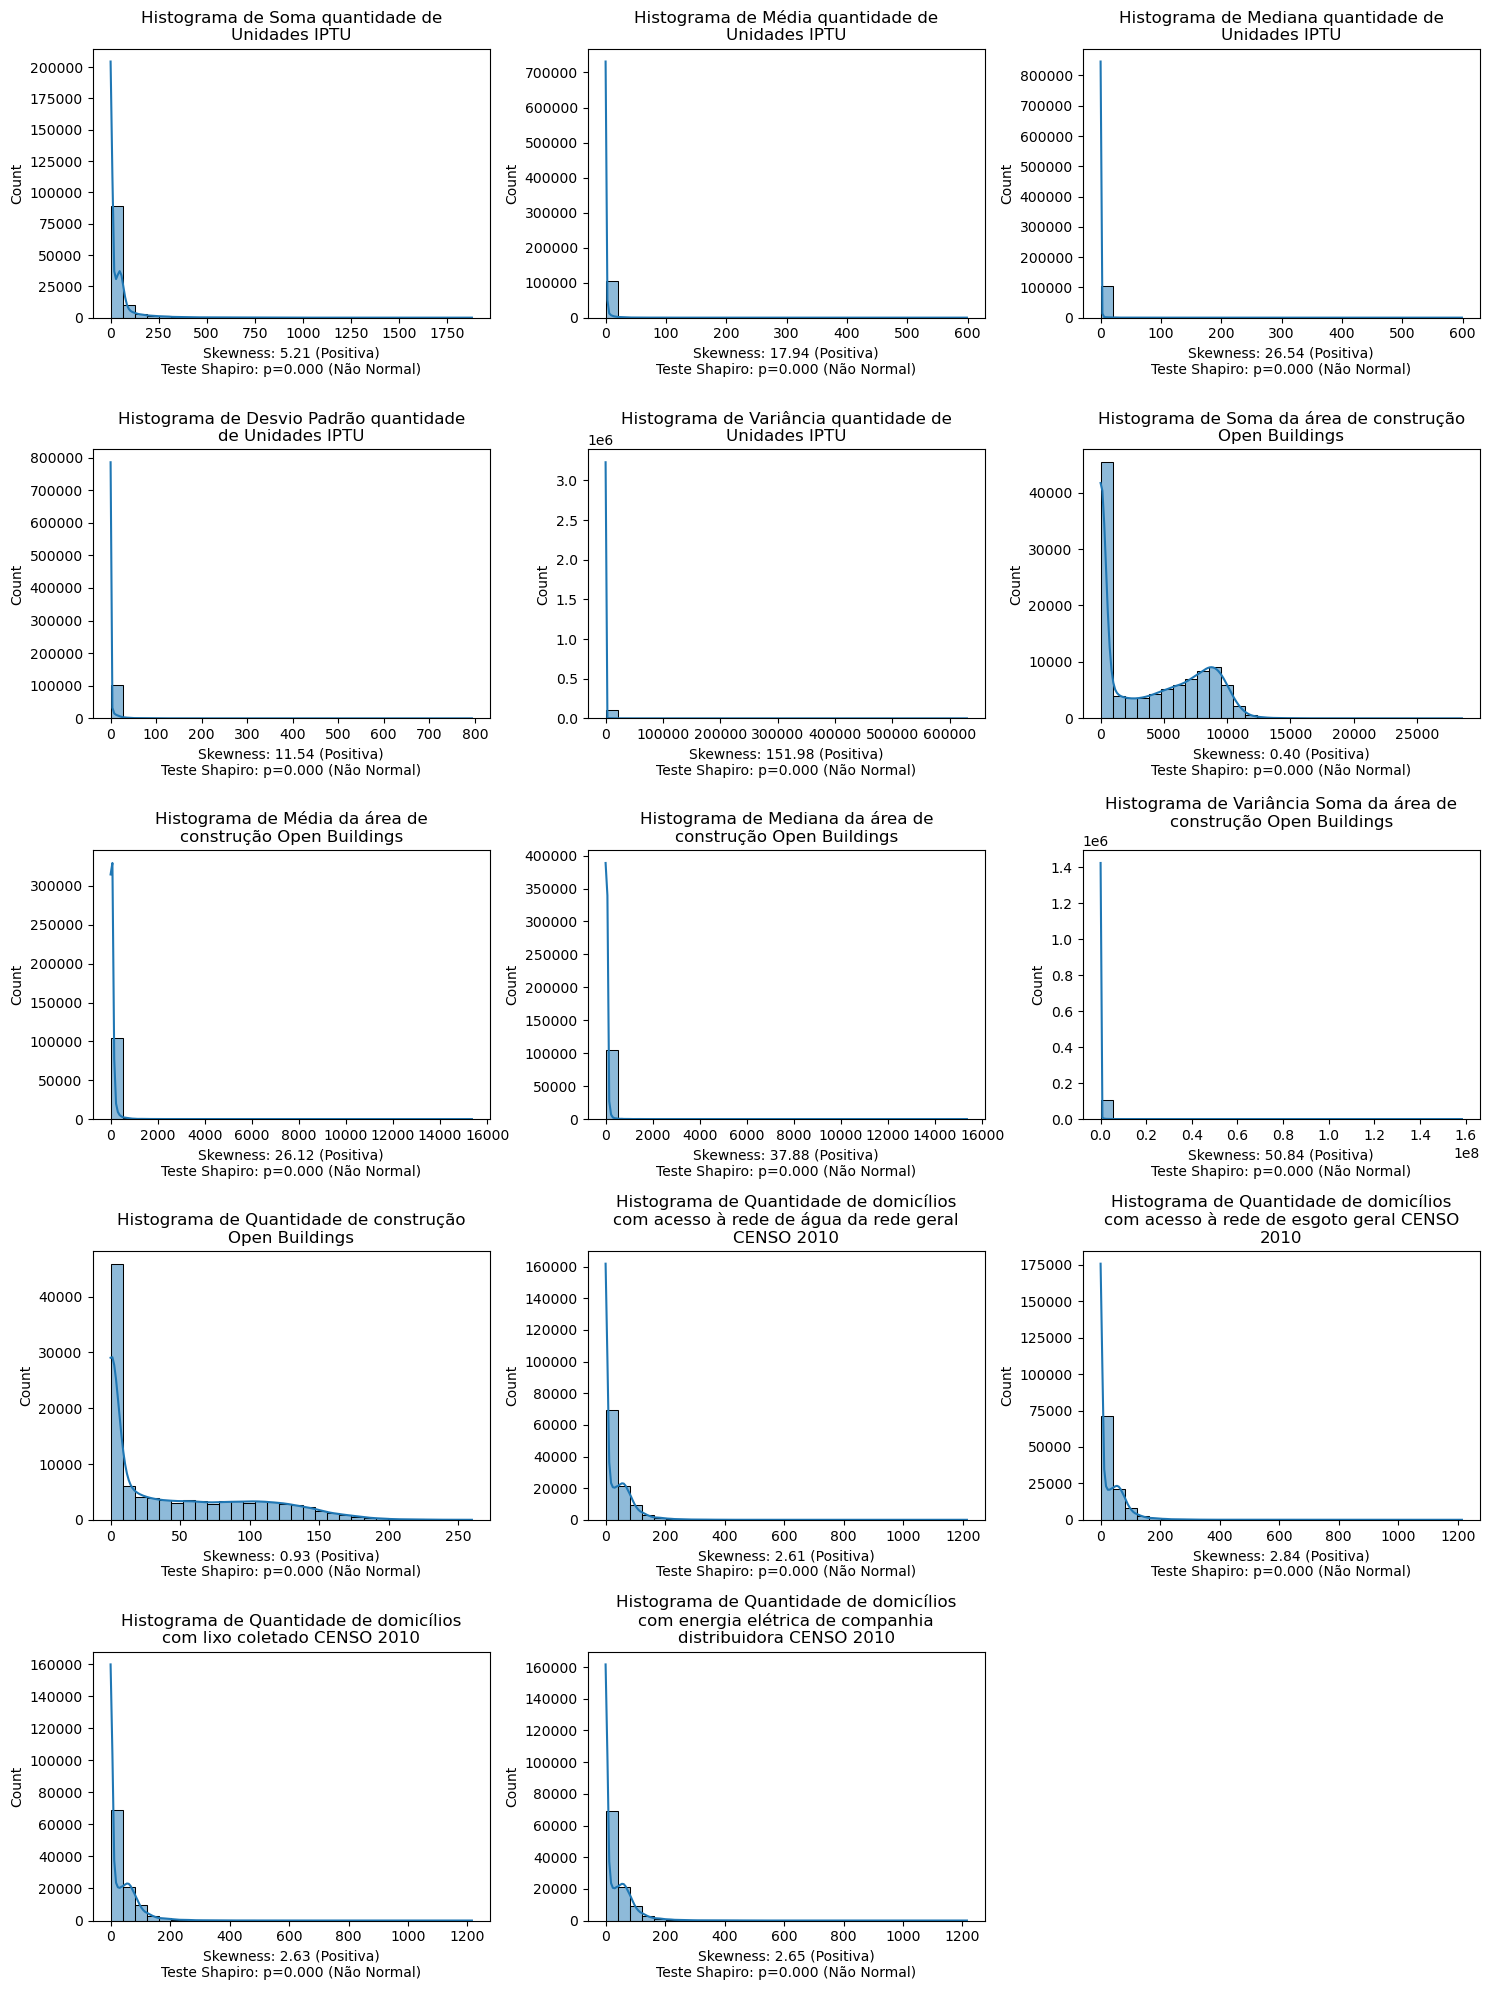

In [22]:
plot_distributions_and_tests(df)

### Analise das Distribuições 
- Nenhum dado é normal 
- Todos tem Skewness positivo -> utilizar Spearman's rank correlation
- Tem uma grande concentração com Zeros, não tem como aplicar log para normalizar

## Testar com dados em log

### Analise

Os dados em log, tem distribuição normal e sem skeness

## Correlação

In [24]:
# Função para calcular a correlação e criar o gráfico
def plot_correlation(df, method="pearson"):
    # Calcular a correlação de Spearman
    corr_matrix = df.corr(method=method)

    # Criar uma máscara para a parte superior da matriz
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Criar um mapa de cores para o gráfico
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Configurar a figura
    plt.figure(figsize=(10, 8))

    # Plotar o mapa de calor da correlação com Seaborn
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .8})

    # Adicionar título
    plt.title(f"{method}'s Correlation", fontsize=16)
    
    # Mostrar o gráfico
    plt.show()

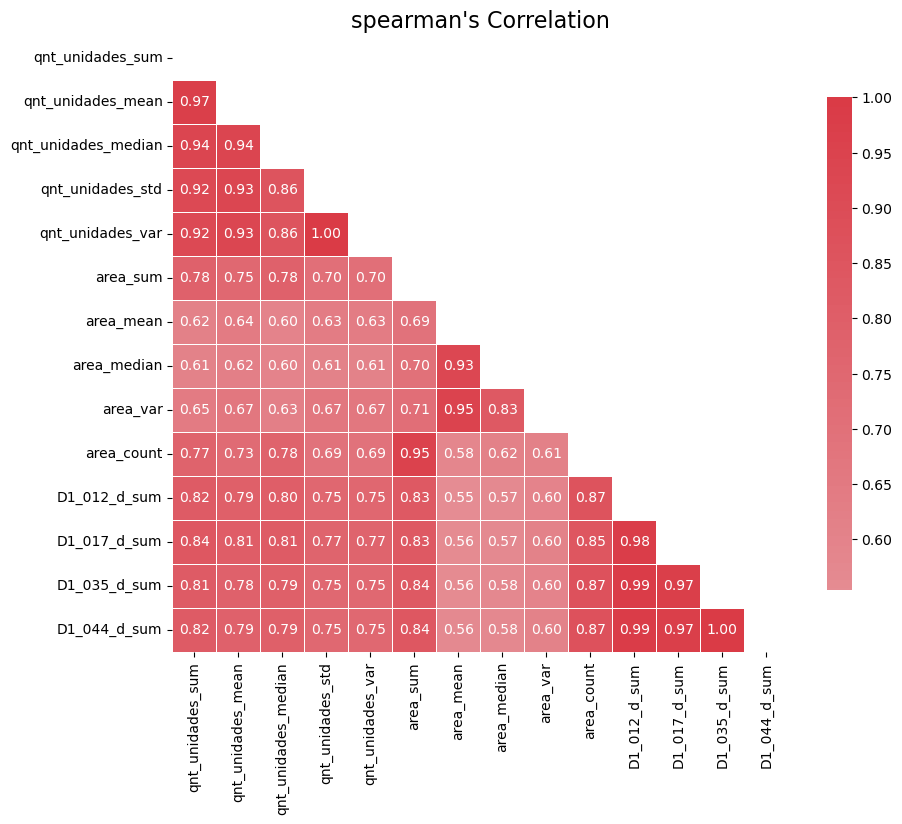

In [25]:
plot_correlation(df, 'spearman')

In [29]:
# Função para aplicar K-means e plotar o coeficiente de silhueta
def find_best_kmeans(data, k_range=(2, 10)):
    # Padronizar os dados para melhorar o desempenho do K-means
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Armazenar os resultados
    silhouette_scores = []
    k_values = list(range(k_range[0], k_range[1] + 1))
    
    # Testar diferentes valores de K
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, init="random", n_init=1000)
        cluster_labels = kmeans.fit_predict(scaled_data)
        silhouette_avg = silhouette_score(scaled_data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    # Plotar o coeficiente de silhueta
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouette_scores, 'bo-', color='blue', marker='o', label='Silhouette Score')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Silhouette Coefficient')
    plt.title('Silhouette Coefficient for different values of K')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()
    
    # Escolher o melhor valor de K (máximo coeficiente de silhueta)
    best_k = k_values[np.argmax(silhouette_scores)]
    print(f"Best K: {best_k} with Silhouette Coefficient: {max(silhouette_scores)}")
    
    # Treinar o KMeans com o melhor K
    best_kmeans = KMeans(n_clusters=best_k, random_state=42)
    best_kmeans.fit(scaled_data)
    
    # Retornar os centróides e rótulos do cluster
    centroids = scaler.inverse_transform(best_kmeans.cluster_centers_)  # Desescalonar para os valores originais
    return best_k, centroids, best_kmeans.labels_

# Analise dos dados indices para identificação de Assentamentos Precários
- Índice de regularidade fundiária dos endereços residenciais
    - CNEFE: Apenas domicílios particulares
    - IPTU: Apenas lançamentos com uso residencial
- Indices de infraestrutura urbana


## Analise de cluster por Regularidade Fundiária

In [43]:
regul_fun = ["qnt_unidades_sum", "esp_1"]

/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_59900/2488691842.py:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(k_values, silhouette_scores, 'bo-', color='blue', marker='o', label='Silhouette Score')
/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_59900/2488691842.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(k_values, silhouette_scores, 'bo-', color='blue', marker='o', label='Silhouette Score')


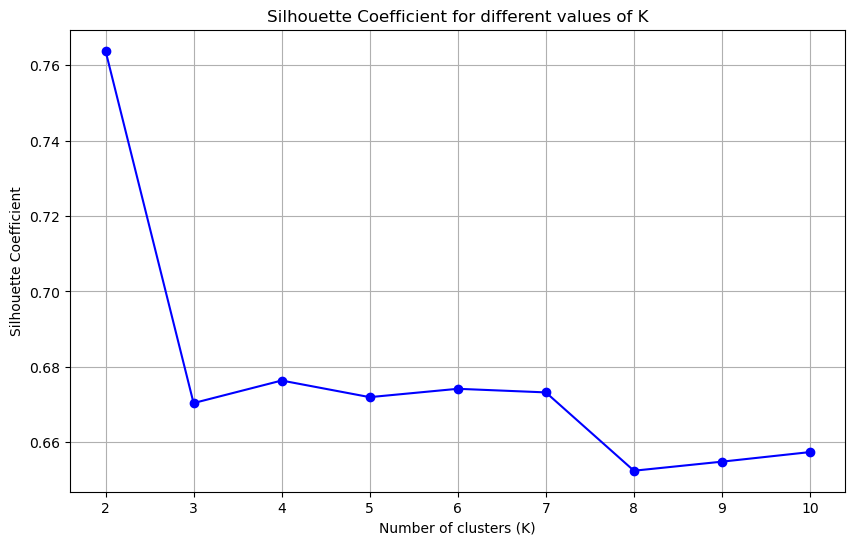

Best K: 2 with Silhouette Coefficient: 0.7638093236577503


In [56]:
best_k, centroids, labels = find_best_kmeans(df[regul_fun], k_range=(2, 10))

### Visulizar do cluster com melhor métrica

In [57]:
regul_fun_cluster_df = pd.concat(
         [df[regul_fun], dados['geometry'], pd.DataFrame(labels, columns=["cluster"])],
          axis=1)

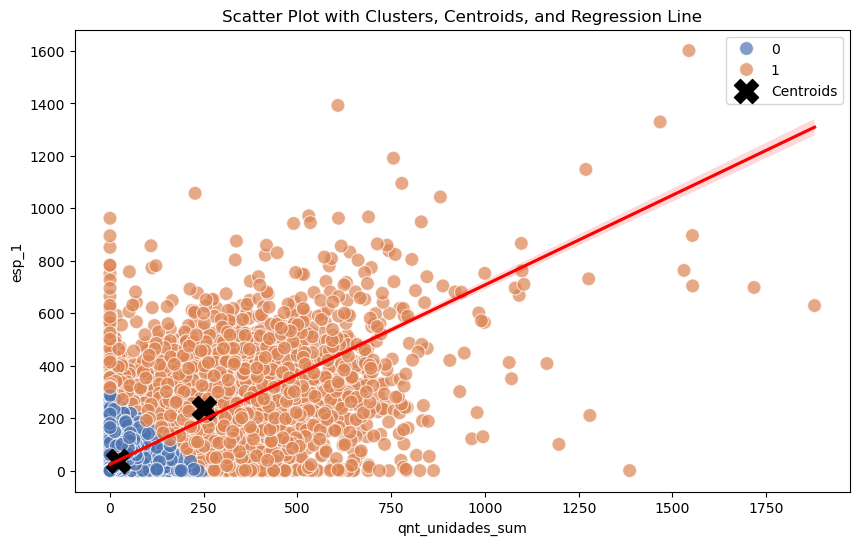

In [58]:

# Plot the scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot of points, colored by cluster
sns.scatterplot(data=regul_fun_cluster_df, x="qnt_unidades_sum", y='esp_1', hue='cluster', palette='deep', s=100, alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='black', marker='X', label='Centroids')
sns.regplot(data=regul_fun_cluster_df,x="qnt_unidades_sum", y='esp_1', scatter=False, color='red', line_kws={"label": "Regression Line"})

# Add titles and labels
plt.title('Scatter Plot with Clusters, Centroids, and Regression Line')
plt.legend()
plt.show()

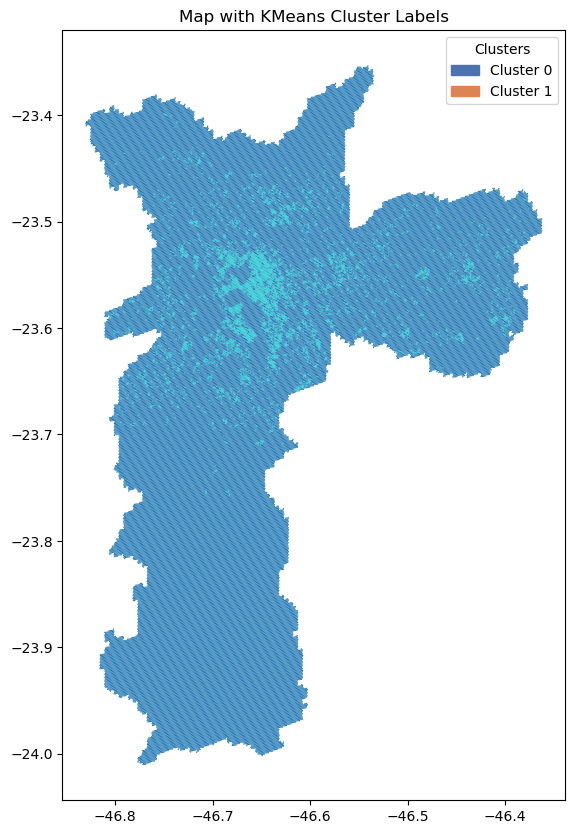

In [59]:
# Use the same color palette as in the scatter plot
palette = sns.color_palette('deep', n_colors=len(regul_fun_cluster_df['cluster'].unique()))

# Map cluster labels to colors
regul_fun_cluster_df['color'] = regul_fun_cluster_df['cluster'].map(dict(zip(range(len(palette)), palette)))

fig, ax = plt.subplots(figsize=(10, 10))
(gpd.
 GeoDataFrame(
    regul_fun_cluster_df,
       geometry="geometry",
       crs=DEFAULT_CRS)
 ).plot(ax=ax, column="color")

#Create the legend with cluster numbers
legend_labels = [mpatches.Patch(color=palette[i], label=f'Cluster {i}') for i in range(len(palette))]
plt.legend(handles=legend_labels, title="Clusters", loc='upper right')

# Add titles and labels
plt.title('Map with KMeans Cluster Labels')
plt.show()

In [11]:
print(f"Centróides para o melhor K={best_k}:\n", centroids)

Centróides para o melhor K=8:
 [[4.06115277e+04 7.79032503e+01]
 [3.87381188e+02 4.07290745e+00]
 [8.20714337e+03 2.43363702e+02]
 [3.83710973e+03 9.99196936e+01]
 [1.88635350e+04 4.12697913e+01]
 [1.46360395e+04 4.86204059e+02]
 [2.24182840e+04 1.37202639e+02]
 [6.89555563e+04 8.95520505e+01]]


### Adicionar cluster nos dataframe

In [ ]:
dados['cluster_regularidade_fundiaria'] = labels

# Analise dos dados indices de infraestrutura urbana
- Dados censitários:
    - percentual de domicílios com acesso à rede de água da rede geral (D1_012)
    - à rede de esgoto geral (D1_017)- 
    - com lixo coletado (D1_035), 
    - com energia elétrica de companhia distribuidora (D1_044))



In [26]:
infra_urban_var = ['D1_012_d_sum', "D1_017_d_sum", "D1_035_d_sum", "D1_044_d_sum"]

In [27]:
df[infra_urban_var].head()

,D1_012_d_sum,D1_017_d_sum,D1_035_d_sum,D1_044_d_sum
0,122.0,122.0,122.0,122.0
1,97.0,97.0,97.0,96.0
2,64.0,64.0,64.0,64.0
3,249.0,248.0,249.0,248.0
4,0.0,0.0,0.0,0.0


In [ ]:
best_k, best_centroids, best_labels = find_best_kmeans(df[infra_urban_var], k_range=(2, 10))

In [23]:
infra_urban_best_df = pd.concat(
         [df[infra_urban_var], dados['geometry'], pd.DataFrame(best_labels, columns=["cluster"])],
          axis=1)

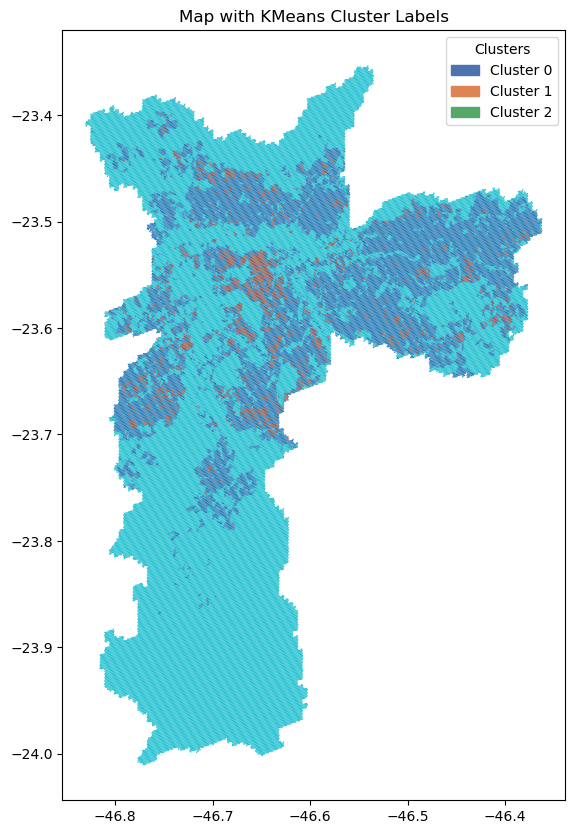

In [24]:
# Use the same color palette as in the scatter plot
palette = sns.color_palette('deep', n_colors=len(infra_urban_best_df['cluster'].unique()))

# Map cluster labels to colors
infra_urban_best_df['color'] = infra_urban_best_df['cluster'].map(dict(zip(range(len(palette)), palette)))

fig, ax = plt.subplots(figsize=(10, 10))
(gpd.
 GeoDataFrame(
    infra_urban_best_df,
       geometry="geometry",
       crs=DEFAULT_CRS)
 ).plot(ax=ax, column="color")

#Create the legend with cluster numbers
legend_labels = [mpatches.Patch(color=palette[i], label=f'Cluster {i}') for i in range(len(palette))]
plt.legend(handles=legend_labels, title="Clusters", loc='upper right')

# Add titles and labels
plt.title('Map with KMeans Cluster Labels')
plt.show()

# Geral

In [30]:
# Definir intervalo de K (de 2 a 10 por exemplo)
best_k, centroids, labels = find_best_kmeans(df, k_range=(2, 10))


KeyboardInterrupt: 

In [65]:
#Exibir os centróides para cada cluster
print(f"Centróides para o melhor K={best_k}:\n", centroids)

Centróides para o melhor K=3:
 [[1.74495194e+04 7.88928846e+03 9.47124486e+01 6.18641554e+01
  1.09608315e+02 3.81199183e+04 9.96586784e+01 4.38228535e-01
  1.13131477e+02 1.27894442e+02 7.95877611e+01 7.42523757e+01
  7.98647856e+01 7.91744717e+01]
 [1.77790525e+03 1.25223034e+03 7.10741219e+01 4.08754921e+01
  8.88260924e+01 7.07952947e+04 1.01425866e+01 6.95760991e-02
  5.59911504e+00 7.04004037e+00 5.67456917e+00 4.85156032e+00
  5.88169539e+00 5.74660767e+00]
 [2.96027500e+03 1.06532765e+04 4.79802994e+03 3.69252589e+03
  4.07648622e+03 2.46278448e+07 2.85000000e+00 5.91813449e-01
  8.00000000e-01 1.13750000e+00 7.97500000e+00 7.63125000e+00
  7.99375000e+00 7.96875000e+00]]
